## NHL Season Outcome Multiple Linear Regression EDA

### Description

The following EDA analysis explores NHL team season data from 1983 - 2020.

The data will be used to predict season outcomes. 

Season outcomes are calculated by how many adjusted games a team wins **(wins + (ties / 2))** above the mean adjusted wins of any given season. The season outcome (target variable) is calculated this way due to the varying nature of hockey; in some seasons, teams are closer in regards to games won and some have a greater divide. In addition, some seasons are longer than other seasons and by using the adjusted games a team wins **(wins + (ties / 2))** above the mean adjusted wins of any given season metric, all seasons were included in the analysis despite some seasons having less games played (shortened due to strike and pandemic).

By predicting and understanding what variables can help predict season outcomes, NHL team organizations can potentially greater their chances of achieving successful campaigns leading to increased revenue for all stakeholders through ticket sales, salary increases, endorsement deals, fair book value of the organization, greater economic activity for the represented city, etc.

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from ipynb.fs.full.Preprocessing_Functions import *

### Data Preprocessing and Feature Engineering

In [6]:
# Import NHL team season stats data frame

# The data can be accesses via GitHub or the local directory
# The data is import via GitHub
local_directory = 'Data/1983_2020_NHL_Season_Data.csv'
GitHub_link = 'https://raw.githubusercontent.com/joseppbenvenuto/NHL_Regression_Classification_Analysis/master/Regression_Analysis/Data/1983_2020_NHL_Season_Data.csv'
nhl_df = pd.read_csv(GitHub_link)

# Convert year range feature into a string data type
nhl_df['year_range'] = nhl_df['year_range'].astype(str)

# Drop uneeded features
nhl_df = nhl_df.drop(['Unnamed: 0', 'id'], axis = 1)

# Failed shots per game feature
nhl_df['failedShotsPerGame'] = nhl_df['shotsPerGame'] * (1 - (nhl_df['shootingPctg'] / 100))
# Saves per game feature
nhl_df['savesPerGame'] = nhl_df['shotsAllowed'] * nhl_df['savePctg']

# Percentage of game won where the team scored first feature
# Teams who win 61% of the time they score first are labeled as high and the opposite as low
nhl_df['winScoreFirstGreater61'] = nhl_df['winScoreFirst']
nhl_df['winScoreFirstGreater61'][nhl_df['winScoreFirstGreater61'] > 0.611] = 'high'
nhl_df['winScoreFirstGreater61'][nhl_df['winScoreFirstGreater61'] != 'high'] = 'low'

# Tie games feature
nhl_df['ties'] = nhl_df['gamesPlayed'] - nhl_df['wins'] - nhl_df['losses']

# Adjusted wins calculated as total wins plus ties where two ties equate to one game won
nhl_df['adjWins'] = nhl_df['wins'] + (nhl_df['ties'] / 2)

# Claculate and remove adjusted wins outliers
outliers = remove_outliers(df = nhl_df, col = 'adjWins')
nhl_df = nhl_df.loc[(nhl_df['adjWins'] > outliers[1]) & (nhl_df['adjWins'] < outliers[3])].reset_index(drop = True)

# Move ajusted wins feature to the end of the data frame
nhl_df = nhl_df[[c for c in nhl_df if c not in ['adjWins']] + ['adjWins']]

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gamesPlayed             887 non-null    int64  
 1   wins                    887 non-null    int64  
 2   losses                  887 non-null    int64  
 3   ot                      887 non-null    int64  
 4   pts                     887 non-null    int64  
 5   ptPctg                  887 non-null    float64
 6   goalsPerGame            887 non-null    float64
 7   goalsAgainstPerGame     887 non-null    float64
 8   evGGARatio              887 non-null    float64
 9   powerPlayPercentage     887 non-null    float64
 10  powerPlayGoals          887 non-null    float64
 11  powerPlayGoalsAgainst   887 non-null    float64
 12  powerPlayOpportunities  887 non-null    float64
 13  penaltyKillPercentage   887 non-null    float64
 14  shotsPerGame            887 non-null    

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,shotsAllowed,winScoreFirst,winOppScoreFirst,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,name,year_range,failedShotsPerGame,savesPerGame,winScoreFirstGreater61,ties,adjWins
0,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52.0,83.0,363.0,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0.0,0.0,0.0,0.0,10.9,0.863,New Jersey Devils,19831984,23.511263,27.616000,low,7,20.5
1,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63.0,66.0,280.0,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0.0,0.0,0.0,0.0,14.7,0.899,New York Islanders,19831984,25.824575,30.015363,high,4,52.0
2,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74.0,76.0,295.0,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0.0,0.0,0.0,0.0,12.3,0.880,New York Rangers,19831984,27.965338,27.764000,high,9,46.5
3,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64.0,85.0,317.0,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0.0,0.0,0.0,0.0,11.9,0.873,Philadelphia Flyers,19831984,32.376750,25.011450,high,10,49.0
4,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71.0,86.0,339.0,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0.0,0.0,0.0,0.0,11.2,0.866,Pittsburgh Penguins,19831984,25.163700,31.479100,low,6,19.0


The above code imports the original data for seasons 1983 - 2020. 

Intuitively  Unnamed: 0 (row index) and id (team id) are removed from the data.

additional features are derived:

* **Failed shots per game (failedShotsPerGame)** - Shots that did not translate into goals.<br><br>
* **Saves per game (savesPerGame)** - Shots against that did not translate into goals against.<br><br>
* **Ties per season (ties)** - (total games per season - (wins + losses)).<br><br>
* **Win percentage when teams scored first (winScoreFirstGreater61)** - Teams that won **greater than 61%** of the games where they scored first are labeled **high** and teams that won **less than or equal to 61%** of the games where they scored first are labeled **low**. This variable was derived using CHAID decision tree algorithm to find significant relationships within the data. <br><br>
* **Adjusted wins (adjWins)** - (total wins + (ties / 2)).<br>

The outliers are removed from adjWins.

In [7]:
# Import NHL team season stats data frame
yearly_mean = pd.read_csv(GitHub_link)

# Convert year range feature into a string data type
yearly_mean['year_range'] = yearly_mean['year_range'].astype(str)

# Tie games feature
yearly_mean['ties'] = yearly_mean['gamesPlayed'] - yearly_mean['wins'] - yearly_mean['losses']

# Adjusted wins calculated as total wins plus ties where two ties equate to one game won
yearly_mean['adjWins'] = yearly_mean['wins'] + (yearly_mean['ties'] / 2)

# Keep year range and adjusted wins features
yearly_mean = yearly_mean[['year_range', 'adjWins']]

# Calculate high and low end outliers for adjusted wins and remove them from the data set
outliers = remove_outliers(df = yearly_mean, col = 'adjWins')
yearly_mean = yearly_mean.loc[(yearly_mean['adjWins'] > outliers[1]) & 
                              (yearly_mean['adjWins'] < outliers[3])].reset_index(drop = True)

# Group by year range and average the adjusted wins per year range
yearly_mean = yearly_mean.groupby(by = ['year_range']).mean().reset_index()
yearly_mean.columns = ['year_range', 'meanAdjWins']

# Print data summary
print('\n')
yearly_mean.info()
yearly_mean.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year_range   36 non-null     object 
 1   meanAdjWins  36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 496.0+ bytes


,year_range,meanAdjWins
0,19831984,39.970588
1,19841985,40.058824
2,19851986,40.000000
3,19861987,39.911765
4,19871988,41.352941


To derive our target variable **(adjusted wins above the mean of individual seasons)**, the average adjusted wins per season (year rage) is calculated.

Adjusted wins outliers are removed before the mean is calculated to accomodate outliers being removed earlier.

In [9]:
# Merge two data frames
nhl_df = nhl_df.merge(yearly_mean, on = 'year_range')

# Calculate target variable
nhl_df['aboveMeanAdjWins'] = nhl_df['adjWins'] - nhl_df['meanAdjWins']

# Remove unneeded features
nhl_df = nhl_df.drop(['adjWins', 'meanAdjWins'], axis = 1)

# Multiply savePctg by 100 to get percent
nhl_df['savePctg'] = nhl_df['savePctg'] * 100

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 886
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gamesPlayed             887 non-null    int64  
 1   wins                    887 non-null    int64  
 2   losses                  887 non-null    int64  
 3   ot                      887 non-null    int64  
 4   pts                     887 non-null    int64  
 5   ptPctg                  887 non-null    float64
 6   goalsPerGame            887 non-null    float64
 7   goalsAgainstPerGame     887 non-null    float64
 8   evGGARatio              887 non-null    float64
 9   powerPlayPercentage     887 non-null    float64
 10  powerPlayGoals          887 non-null    float64
 11  powerPlayGoalsAgainst   887 non-null    float64
 12  powerPlayOpportunities  887 non-null    float64
 13  penaltyKillPercentage   887 non-null    float64
 14  shotsPerGame            887 non-null    

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,shotsAllowed,winScoreFirst,winOppScoreFirst,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,name,year_range,failedShotsPerGame,savesPerGame,winScoreFirstGreater61,ties,aboveMeanAdjWins
0,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52.0,83.0,363.0,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0.0,0.0,0.0,0.0,10.9,86.3,New Jersey Devils,19831984,23.511263,27.616000,low,7,-19.470588
1,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63.0,66.0,280.0,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0.0,0.0,0.0,0.0,14.7,89.9,New York Islanders,19831984,25.824575,30.015363,high,4,12.029412
2,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74.0,76.0,295.0,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0.0,0.0,0.0,0.0,12.3,88.0,New York Rangers,19831984,27.965338,27.764000,high,9,6.529412
3,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64.0,85.0,317.0,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0.0,0.0,0.0,0.0,11.9,87.3,Philadelphia Flyers,19831984,32.376750,25.011450,high,10,9.029412
4,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71.0,86.0,339.0,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0.0,0.0,0.0,0.0,11.2,86.6,Pittsburgh Penguins,19831984,25.163700,31.479100,low,6,-20.970588


The complete data set is generated.

### Data Exploration, Feature Engineering, and Feature Selection

#### Univariate Analysis

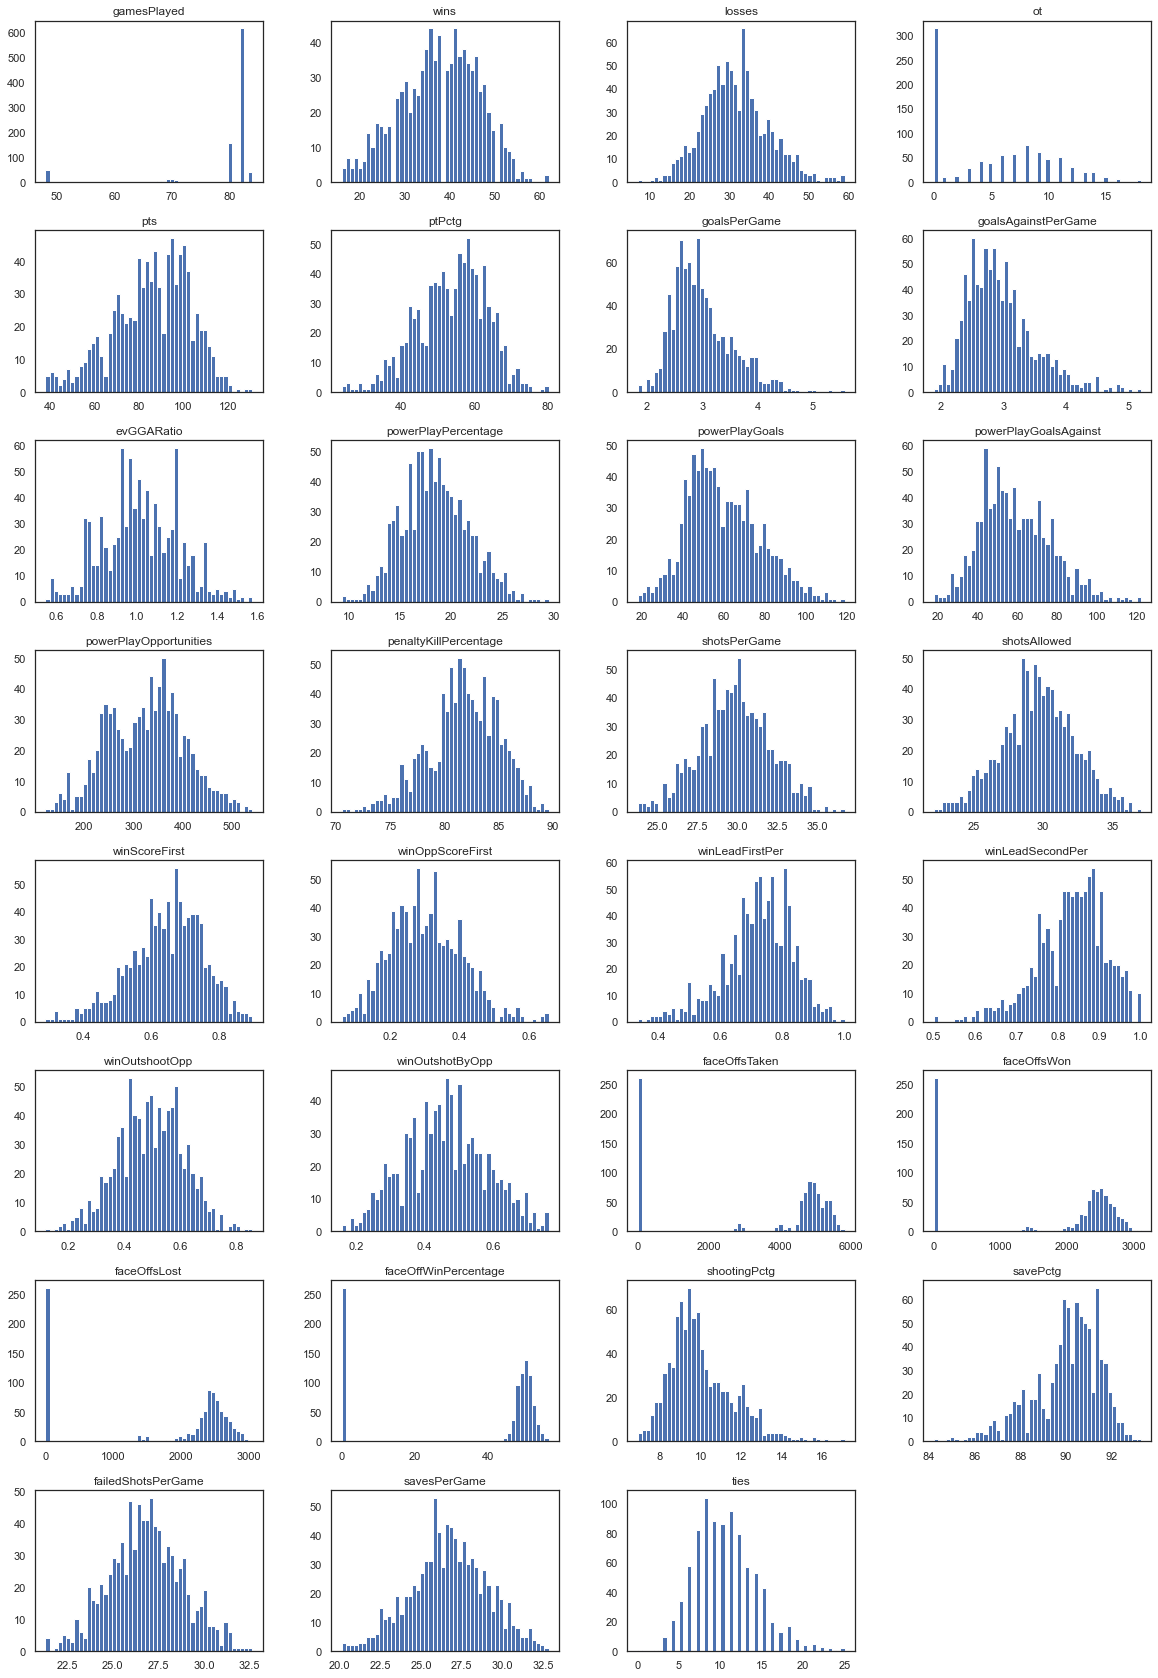


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
gamesPlayed,887.0,79.515220,7.826097,48.000000,80.000000,82.00000,82.000000,84.000000
wins,887.0,37.636979,8.656024,16.000000,32.000000,38.00000,44.000000,62.000000
losses,887.0,31.525366,8.197972,7.000000,26.000000,31.00000,37.000000,59.000000
ot,887.0,5.228861,4.757143,0.000000,0.000000,5.00000,9.000000,18.000000
pts,887.0,85.626832,17.192690,38.000000,74.000000,87.00000,99.000000,131.000000
ptPctg,887.0,53.873844,9.459197,23.800000,47.600000,54.90000,61.000000,80.200000
goalsPerGame,887.0,2.988316,0.532402,1.829000,2.610000,2.89000,3.268000,5.575000
goalsAgainstPerGame,887.0,2.950259,0.530932,1.890000,2.561000,2.85400,3.207000,5.188000
evGGARatio,887.0,1.017013,0.187862,0.544400,0.899050,1.00690,1.154500,1.575200
powerPlayPercentage,887.0,18.425028,3.240092,9.300000,16.100000,18.20000,20.600000,29.500000


In [10]:
# Distributions of numeric continuous perdictor variables
num_univariate_histogram(df = nhl_df, length = 30, width = 20, rows = 8, col = 4, font = 1, kind = 1)

### The numeric features that will not be used due to data integrity and variables that are equivalent to the target variable:

* **Games played (gamesPlayed)** - Due to strikes and Covid-19, there are shortened seasons in the range of 48 - 70 games played. No significant adjustments will be made because this will not affect the analysis.<br><br>

* **Losses (losses)** - Intuitively, losses will not be included in the analysis because this feature simply is the opposite of the target variable and will cause our analysis to generate no added value.<br><br>

* **Points (pts)** - Intuitively, points will not be included in the analysis for similar reasons as losses.<br><br>

* **Point percentage (ptPctg)** - Intuitively, point percentage will not be included in the analysis for similar reasons as losses.<br><br>

* **EVGGARatio (evGGARatio)** - EVGGARatio will not be included in the analysis because, despite the possibility it may provide predictive value, the metric remains unknown. If a decent result cannot be generated, this feature may be re-included to try and achieve better results.<br><br>

* **Power-play goals (powerPlayGoals)** - Power play goals will not be included because it is out of a team's direct control. Penalties only occur when officials call them against an opposing team.<br><br>

* **Power-play goals-against (powerPlayGoalsAgainst)** - Power-play goals against will not be included in the analysis for similar reasons as power-play goals.<br><br>

* **Power-play opportunities (powerPlayOpportunities)** - Power play opportunities will not be included in the analysis for similar reasons as power-play goals.<br><br>

* **Overtime (ot)** - There are many missing data records or simply overtime was not played during the earlier seasons. This feature will produce misleading results and will not be included in the analysis.<br><br>

* **Face-off features (all)** - All features regarding face-offs will not be included in the analysis because of missing data records in the earlier seasons.<br><br>

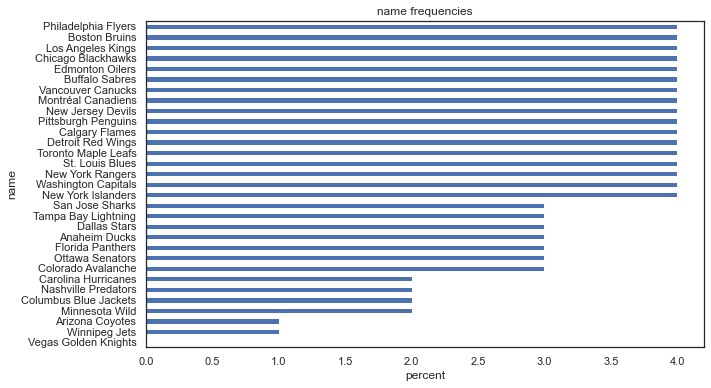

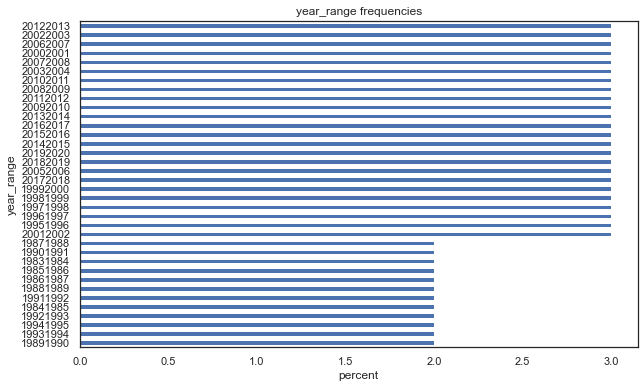

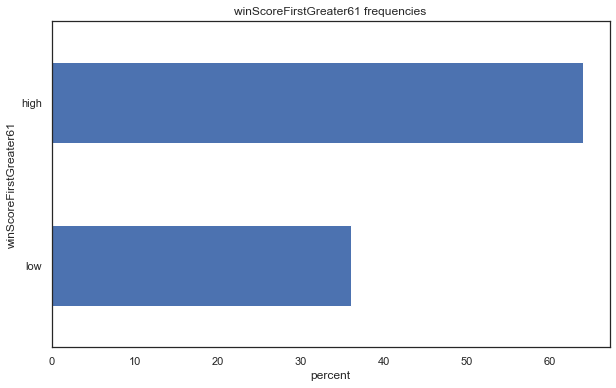

,count,unique
name,887,31
year_range,887,36
winScoreFirstGreater61,887,2


In [11]:
# View frequencies of categorical data
cat_univariate_freq(df = nhl_df, length = 6, width = 10, col_start = 0, col_end = 4, font = 1)
describe = nhl_df.describe(include = object).T.drop(['top', 'freq'], axis = 1, errors = 'ignore')
describe

The frequencies for the categorical features are plotted above, however, winScoreFirstGreater61 is the only feature of to be included in the analysis. 

Year range and team names will not generate any added value because the analysis is looking to help teams understand what metrics they can focus on to improve their seaon outcomes.

In [12]:
# Convert winScoreFirstGreater61 to dummy variable
dummy_col = pd.get_dummies(nhl_df['winScoreFirstGreater61'], drop_first = False).astype(int)
dummy_col = dummy_col.drop(['low'], axis = 1, errors = 'ignore')
nhl_df = pd.concat([dummy_col, nhl_df], axis = 1)
nhl_df.rename(columns = {'high': 'winScoreFirstGreater61_high'}, inplace = True)
nhl_df = nhl_df.drop(['winScoreFirstGreater61'], axis = 1, errors = 'ignore')

nhl_df.info()
nhl_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 886
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   winScoreFirstGreater61_high  887 non-null    int32  
 1   gamesPlayed                  887 non-null    int64  
 2   wins                         887 non-null    int64  
 3   losses                       887 non-null    int64  
 4   ot                           887 non-null    int64  
 5   pts                          887 non-null    int64  
 6   ptPctg                       887 non-null    float64
 7   goalsPerGame                 887 non-null    float64
 8   goalsAgainstPerGame          887 non-null    float64
 9   evGGARatio                   887 non-null    float64
 10  powerPlayPercentage          887 non-null    float64
 11  powerPlayGoals               887 non-null    float64
 12  powerPlayGoalsAgainst        887 non-null    float64
 13  powerPlayOpportuniti

,winScoreFirstGreater61_high,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,shotsAllowed,winScoreFirst,winOppScoreFirst,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,name,year_range,failedShotsPerGame,savesPerGame,ties,aboveMeanAdjWins
0,0,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52.0,83.0,363.0,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0.0,0.0,0.0,0.0,10.9,86.3,New Jersey Devils,19831984,23.511263,27.616000,7,-19.470588
1,1,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63.0,66.0,280.0,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0.0,0.0,0.0,0.0,14.7,89.9,New York Islanders,19831984,25.824575,30.015363,4,12.029412
2,1,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74.0,76.0,295.0,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0.0,0.0,0.0,0.0,12.3,88.0,New York Rangers,19831984,27.965338,27.764000,9,6.529412
3,1,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64.0,85.0,317.0,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0.0,0.0,0.0,0.0,11.9,87.3,Philadelphia Flyers,19831984,32.376750,25.011450,10,9.029412
4,0,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71.0,86.0,339.0,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0.0,0.0,0.0,0.0,11.2,86.6,Pittsburgh Penguins,19831984,25.163700,31.479100,6,-20.970588


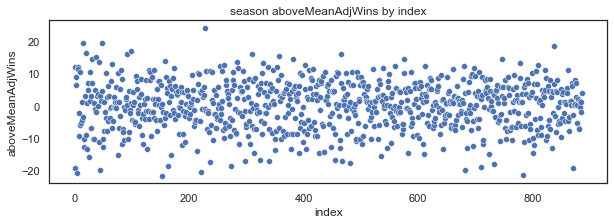

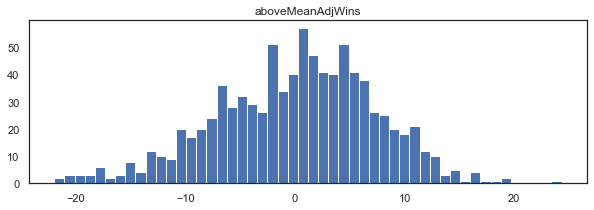


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
aboveMeanAdjWins,887.0,-1.281701e-16,7.316449,-21.944444,-4.855769,0.607143,5.008929,24.3125


In [13]:
# aboveMeanAdjWins by index scatter plot
target_univariate_scatter(df = nhl_df, x = 'index', y = 'aboveMeanAdjWins', length = 3, width = 10, font = 1)

# aboveMeanAdjWins variable distribution
y_hist = nhl_df.copy()
y_hist = y_hist[['aboveMeanAdjWins']]
num_univariate_histogram(df = y_hist, length = 3, width = 10, rows = 1, col = 1, font = 1, kind = 2)

The target variable (aboveMeanAdjWins) appears to be normally distributed as shown by the histogram. The normality also proves that a better model than the mean can be produced. 

Through the histogram and scatter plot, it appears that there are no significant outliers in data, allowing for a more robust model, additionally, the target variable is random shows no apparent bias by the scatter plot.

In [14]:
# Kept features
features_keep = np.array(['goalsPerGame', 'goalsAgainstPerGame', 'powerPlayPercentage', 'penaltyKillPercentage',
                          'shotsPerGame', 'shotsAllowed', 'shootingPctg', 'savePctg', 'savesPerGame',
                          'failedShotsPerGame', 'ties', 'winScoreFirstGreater61_high', 'aboveMeanAdjWins'])

print('kept features due to data integrity and impactfulness: '+'\n'+'\n'+ str(features_keep) + '\n')

kept features due to data integrity and impactfulness: 

['goalsPerGame' 'goalsAgainstPerGame' 'powerPlayPercentage'
 'penaltyKillPercentage' 'shotsPerGame' 'shotsAllowed' 'shootingPctg'
 'savePctg' 'savesPerGame' 'failedShotsPerGame' 'ties'
 'winScoreFirstGreater61_high' 'aboveMeanAdjWins']



In [15]:
# Data frame with kept features
nhl_df = nhl_df[np.array(features_keep)]

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 886
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   goalsPerGame                 887 non-null    float64
 1   goalsAgainstPerGame          887 non-null    float64
 2   powerPlayPercentage          887 non-null    float64
 3   penaltyKillPercentage        887 non-null    float64
 4   shotsPerGame                 887 non-null    float64
 5   shotsAllowed                 887 non-null    float64
 6   shootingPctg                 887 non-null    float64
 7   savePctg                     887 non-null    float64
 8   savesPerGame                 887 non-null    float64
 9   failedShotsPerGame           887 non-null    float64
 10  ties                         887 non-null    int64  
 11  winScoreFirstGreater61_high  887 non-null    int32  
 12  aboveMeanAdjWins             887 non-null    float64
dtypes: float64(11), in

,goalsPerGame,goalsAgainstPerGame,powerPlayPercentage,penaltyKillPercentage,shotsPerGame,shotsAllowed,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,ties,winScoreFirstGreater61_high,aboveMeanAdjWins
0,2.888,4.375,14.3,75.3,26.3875,32.0000,10.9,86.3,27.616000,23.511263,7,0,-19.470588
1,4.463,3.363,22.5,81.5,30.2750,33.3875,14.7,89.9,30.015363,25.824575,4,1,12.029412
2,3.925,3.800,25.1,78.1,31.8875,31.5500,12.3,88.0,27.764000,27.965338,9,1,6.529412
3,4.375,3.625,20.2,76.6,36.7500,28.6500,11.9,87.3,25.011450,32.376750,10,1,9.029412
4,3.175,4.875,20.9,76.0,28.3375,36.3500,11.2,86.6,31.479100,25.163700,6,0,-20.970588


Above is a data frame with features that will be included in the analysis from this point on.

#### Bivariate Analysis

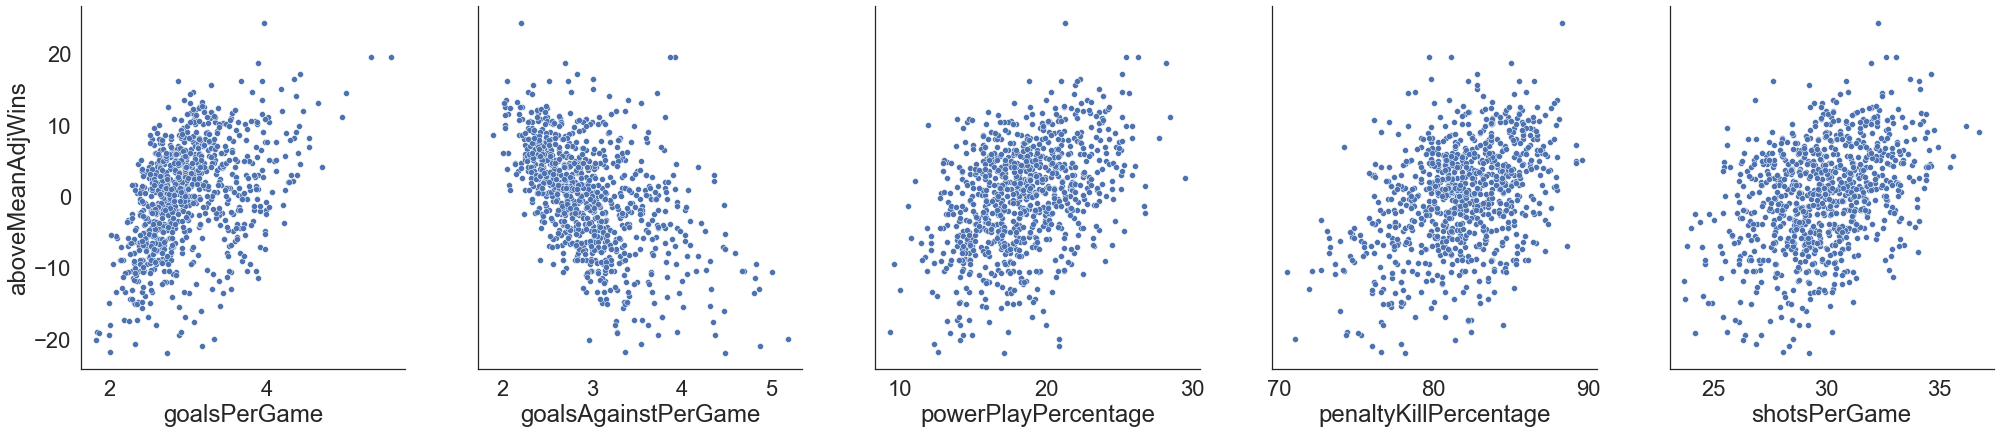

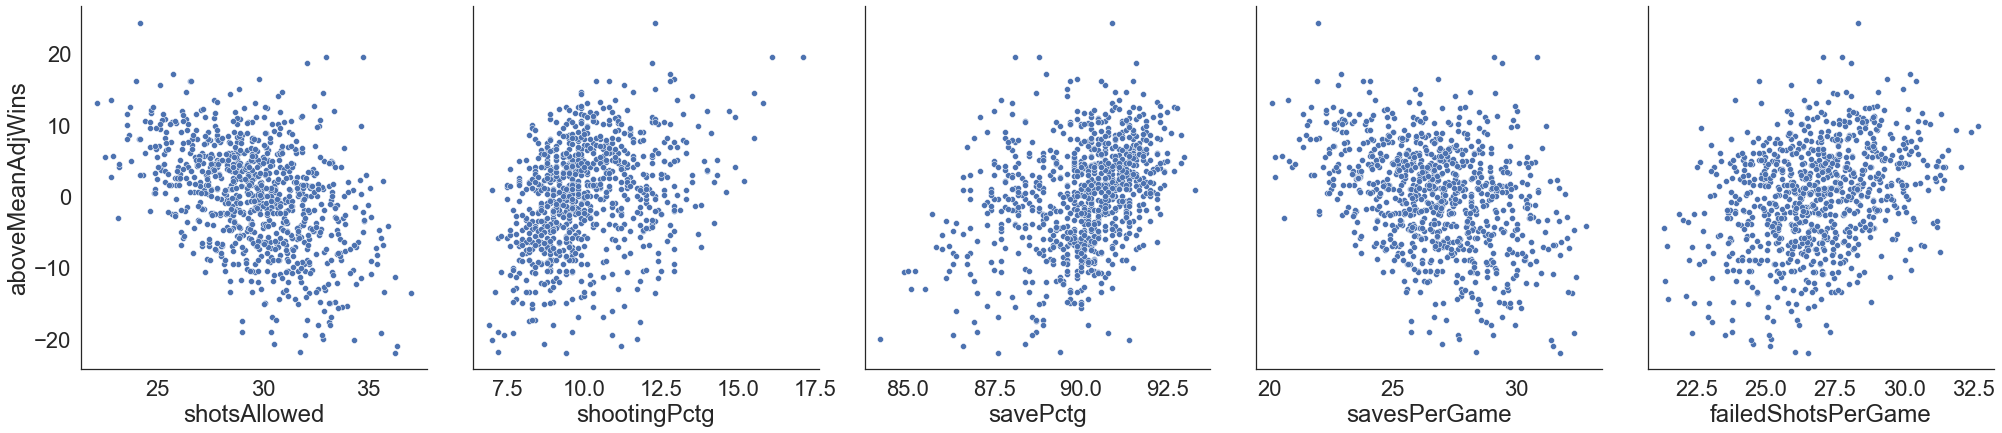

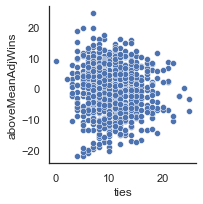

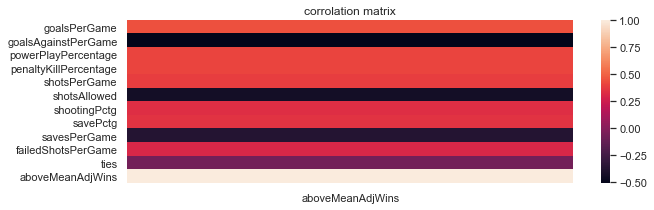

,aboveMeanAdjWins
aboveMeanAdjWins,1.000000
goalsPerGame,0.450773
penaltyKillPercentage,0.414631
powerPlayPercentage,0.414316
shotsPerGame,0.388834
savePctg,0.353393
shootingPctg,0.334139
failedShotsPerGame,0.306724
ties,-0.063276
savesPerGame,-0.363029



features to remove: 
['ties']


In [16]:
# Feature relationship comparison with aboveMeanAdjWins via scatter plots
X_num = nhl_df.copy()
X_num = X_num.columns[0:len(nhl_df.columns)-2]
num_bivariate_scatter(df = nhl_df, y = 'aboveMeanAdjWins', x = X_num[0:5], font = 2, length = 10, width = 30)
num_bivariate_scatter(df = nhl_df, y = 'aboveMeanAdjWins', x = X_num[5:10], font = 2, length = 10, width = 30)
num_bivariate_scatter(df = nhl_df, y = 'aboveMeanAdjWins', x = X_num[10:11], font = 1, length = 3, width = 3)

# Feature relationship comparison with aboveMeanAdjWins via corrolation heat map
X_num = nhl_df.select_dtypes(include = ['float64', 'int64'])
num_bivariate_corr_target(df = X_num, target = 'aboveMeanAdjWins', threshold = 0.20, font = 1, length = 3, width = 10)

The above displays the bivariate analysis for the numeric continuous features with the target variable. 

We can visually see the relationships via scatter plot, heat map, and data frame. 

the ties features noticeably has a very weak relationship with aboveMeanAdjWins and will likely be removed form the data set.

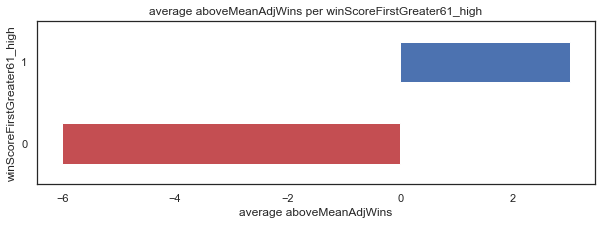

,aboveMeanAdjWins,positive
winScoreFirstGreater61_high,,
1,3.0,True
0,-6.0,False


In [18]:
# Feature relationship comparison with aboveMeanAdjWins via bar chart averages
cat_col = nhl_df.copy()
cat_col = cat_col[['winScoreFirstGreater61_high', 'aboveMeanAdjWins']]
cat_col['winScoreFirstGreater61_high'] = cat_col['winScoreFirstGreater61_high'].astype(str)
cat_bivariate_avg_target(df = cat_col, col_start = 0, col_end = 3, target = 'aboveMeanAdjWins', 
                         length = 3, width = 10, font = 1)

The above displays the bivariate analysis for the only categorical feature with the target variable.

Teams who win greater than 61% of the games they score first in, have a larger average adjusted wins of above the season mean adjusted wins.

The opposite is true for teams who win less than or equal to 61% of games they score first in.

In [19]:
# Export the final data frame to local directory 
nhl_df.to_csv('Data/NHL_1983_2020_Perprocessed_Season_Data_Removed_Outliers.csv')

The newly formed data frame is exported to the project directory for further analysis.